<a href="https://colab.research.google.com/github/mijanr/GANs/blob/master/cGAN_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# add ../src to sys.path
import sys, os
sys.path.append(os.path.abspath('../src'))

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [13]:
from cGAN import Generator, Discriminator

In [5]:
#load the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)

In [6]:
batch_size = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)

In [7]:
class_list = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_num = len(class_list)

In [8]:
#visualize the dataset
def imshow(dataloader):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    img = torchvision.utils.make_grid(images)
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


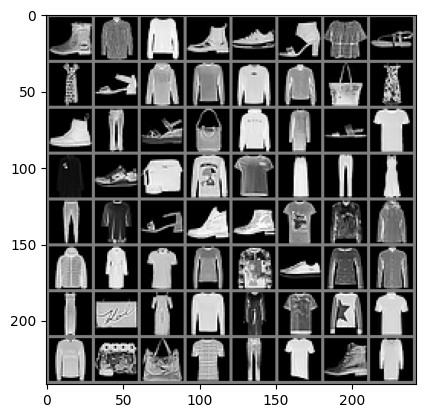

In [9]:
imshow(trainloader)

In [10]:
for images, labels in trainloader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [17]:
noise_dim = 100
image_dim = 784
num_classes = 10

In [18]:
generator = Generator(noise_dim=100, image_dim=784, num_classes=class_num).to(device)
discriminator = Discriminator(image_dim=784, num_classes=class_num).to(device)

In [19]:
#training
criterion = nn.BCELoss()
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

Epoch [5/100], d_loss: 1.3352, g_loss: 0.7914, D(x): 0.49, D(G(z)): 0.42


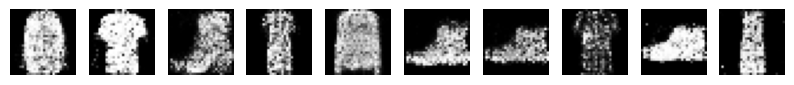

Epoch [10/100], d_loss: 1.3088, g_loss: 0.8201, D(x): 0.53, D(G(z)): 0.47


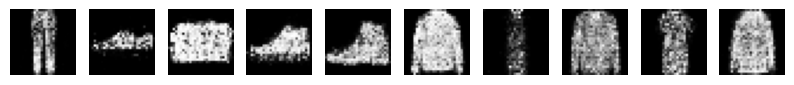

Epoch [15/100], d_loss: 1.3934, g_loss: 0.8318, D(x): 0.51, D(G(z)): 0.49


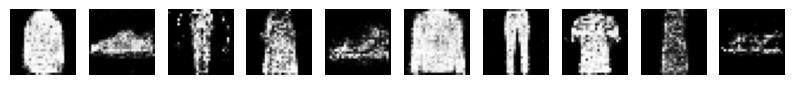

Epoch [20/100], d_loss: 1.3718, g_loss: 0.8238, D(x): 0.50, D(G(z)): 0.46


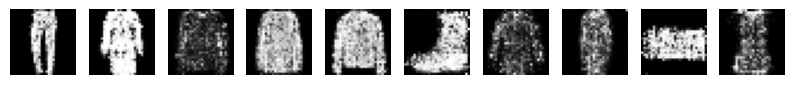

KeyboardInterrupt: 

In [31]:
#training loop
num_epochs = 100
for epoch in range(num_epochs):
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        batch_size = images.shape[0]

        #train discriminator
        discriminator.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        outputs = discriminator(images.view(-1, 28*28), labels)
        real_loss = criterion(outputs, real_labels)
        real_score = outputs

        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_images = generator(noise, labels)
        outputs = discriminator(fake_images, labels)
        fake_loss = criterion(outputs, fake_labels)
        fake_score = outputs

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizerD.step()

        #train generator
        generator.zero_grad()
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_images = generator(noise, labels)
        outputs = discriminator(fake_images, labels)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizerG.step()

    if (epoch+1) % 5 == 0:
        print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                .format(epoch+1, num_epochs, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))
        # generate some images and plot them
        noise = torch.randn(10, noise_dim).to(device)
        labels = torch.randint(0, 10, (10,)).to(device)
        fake_images = generator(noise, labels)
        fake_images = fake_images.view(-1, 28, 28).data.cpu().numpy()
        fig, ax = plt.subplots(1, 10, figsize=(10, 2))
        for i in range(10):
            ax[i].set_axis_off()
            ax[i].imshow(fake_images[i], cmap='gray')
        plt.show()
        plt.close()

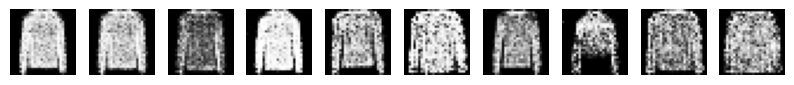

In [36]:
#gernerate image and plot them
noise = torch.randn(10, noise_dim).to(device)
labels = torch.randint(2, 3, (10,)).to(device)
fake_images = generator(noise, labels)
fake_images = fake_images.view(-1, 28, 28).data.cpu().numpy()
fig, ax = plt.subplots(1, 10, figsize=(10, 2))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(fake_images[i], cmap='gray')
plt.show()
plt.close()